In [4]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import csv
import glob

In [5]:
res = {}
for which in ['fez', 'kyiv', 'torino']:
    for ang in [16]:
        for les in [0]:
            for p in range(37):
                fname = Path(f"./results/Hamiltonian_ibm_{which}_0/{ang}_{les}/{p=}/results.csv")
                try:
                    with open(fname, 'r') as f:
                        rd = csv.DictReader(f, delimiter=';', quotechar="'")
                        ind = (which, ang, les, p)
                        res[ind] = list(rd)
                except FileNotFoundError:
                    pass

In [6]:
def plot_energy_lin(ind):

    clrs = {"BP": 'blue', "CTM": 'red', 'MPS': 'green'}
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5, 3)
    miny = 0
    maxy = -1000
    if ind in res:
        for pt in res[ind]:
            mrk = 'x' if pt["chi"] == '1' else '+'
            clr = clrs[pt["env"]]
            ax.scatter([1 / float(pt["D"])], float(pt["eng"]),
                        marker=mrk, color=clr, s=50)
            miny = min(miny, float(pt["eng"]))
            maxy = max(maxy, float(pt["eng"]))

        #ax.set_xscale('log')
        ax.set_xlabel('1 / D')
        ax.set_ylabel(f'eng')
        ax.set_ylim(miny-1, maxy+1)
        ax.set_xlim(0, 1)

        ax.grid(which='major')
        ax.grid(which='minor')
        ax.set_title(f'{ind}')

        ax.scatter([1.2], [1e-2], marker='+', color='black', s=50, label='chi>1')
        ax.scatter([1.2], [1e-2], marker='x', color='black', s=50, label='BP (chi=1)')
        for k, v in clrs.items():
            ax.scatter([1.2], [1e-2], marker='o', color=v, s=50, label=k)

        ax.legend()
    # plt.legend()
# plt.show()

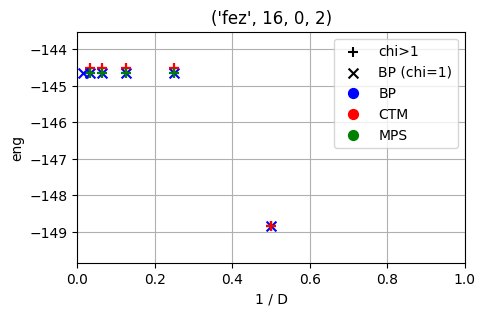

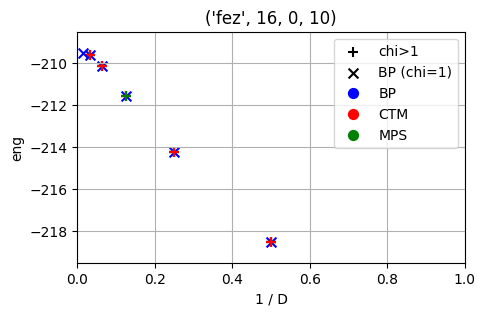

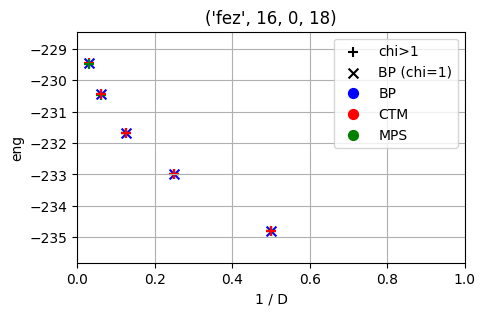

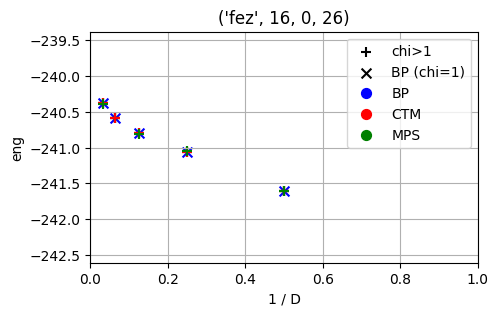

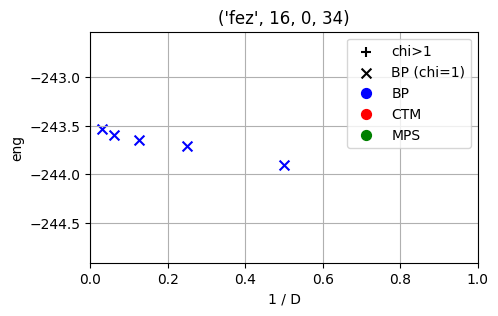

In [7]:
for p in range(2, 37, 8):
    plot_energy_lin(('fez', 16, 0, p))


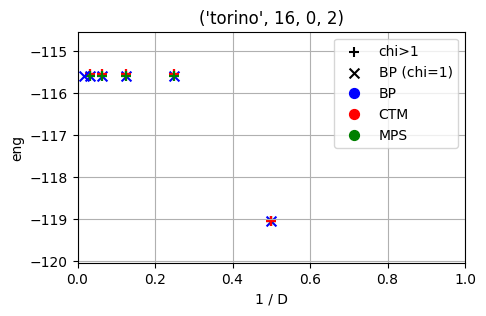

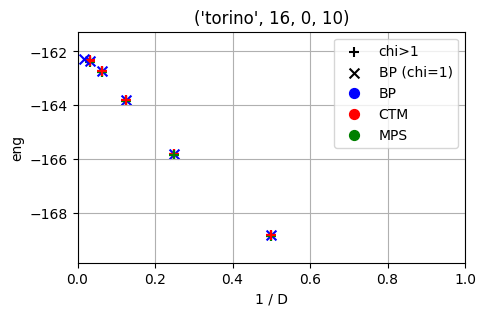

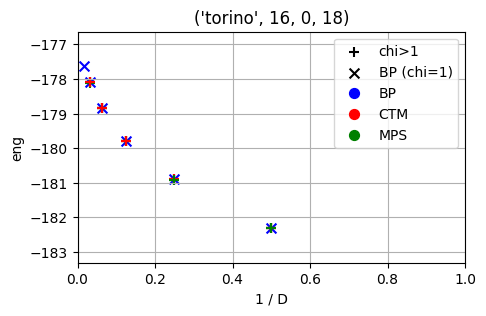

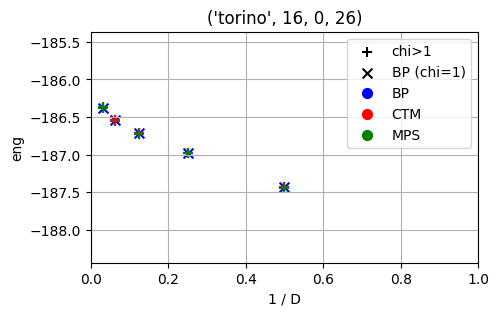

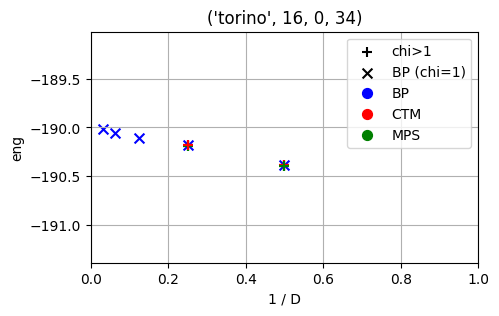

In [20]:
for p in range(2, 37, 8):
    plot_energy_lin(('torino', 16, 0, p))

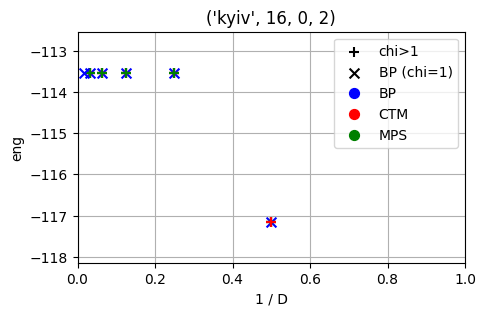

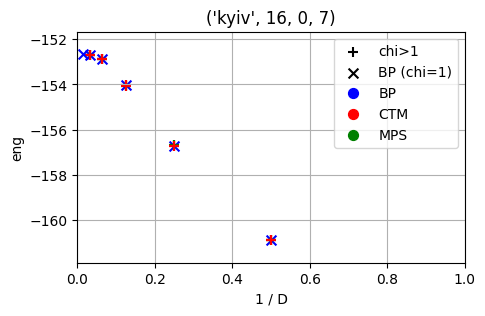

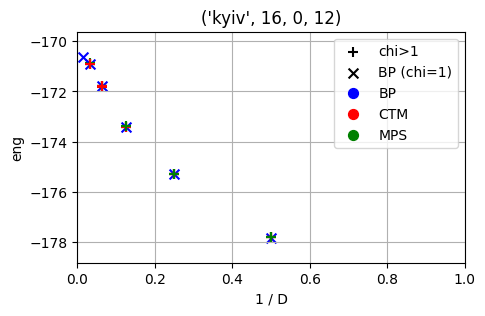

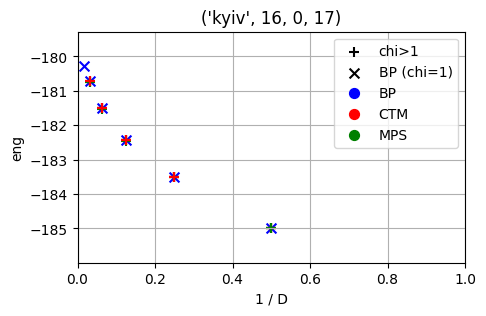

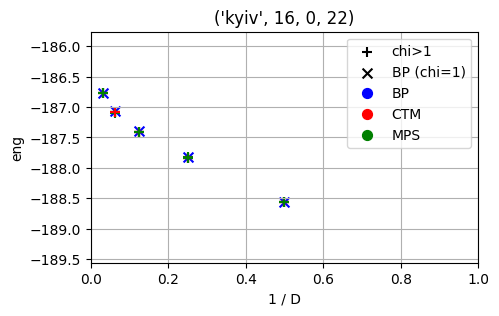

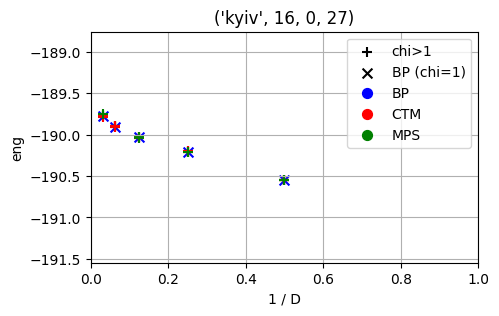

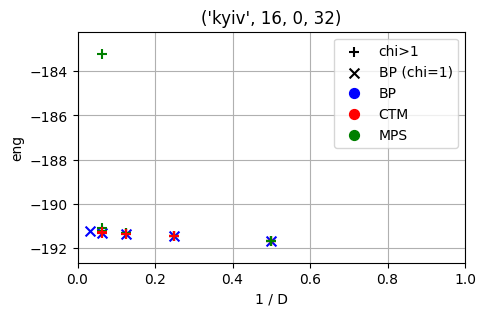

In [9]:
for p in range(2, 37, 5):
    plot_energy_lin(('kyiv', 16, 0, p))

In [21]:
def plot_energy_diff(which, ang, les):

    ps = list(range(4,37))
    evs6432, evs3216= [], []
    for p in ps:
        ind = (which, ang, les, p)
        ev32, ev16, ev64 = 0, 0, 0
        
        for x in res[ind]:
            if x['D'] == '32' and x['env'] == 'BP':
                ev32 = float(x['eng'])
        
        for x in res[ind]:
            if x['D'] == '16' and x['env'] == 'BP':
                ev16 = float(x['eng'])

        for x in res[ind]:
            if x['D'] == '64' and x['env'] == 'BP':
                ev64 = float(x['eng'])
        
        
        evs6432.append((ev64-ev32) if ev64 < -10 else 0)    
        evs3216.append((ev32-ev16))    
    
    clrs = {'fez':'green', 'kyiv':'blue', 'torino':'red'}
    plt.plot(ps, evs6432, '-+', label=f"{which}, E(D=64) - E(D=32)", color=clrs[which])
    plt.plot(ps, evs3216, '-o', label=f"{which}, E(D=32) - E(D=16)", color=clrs[which])

    plt.xlabel('p')
    plt.ylabel(f'energy convergence')


    plt.legend()
# plt.show()

Compare energy (in BP) for D64, D32, D16;  [convergence with D]

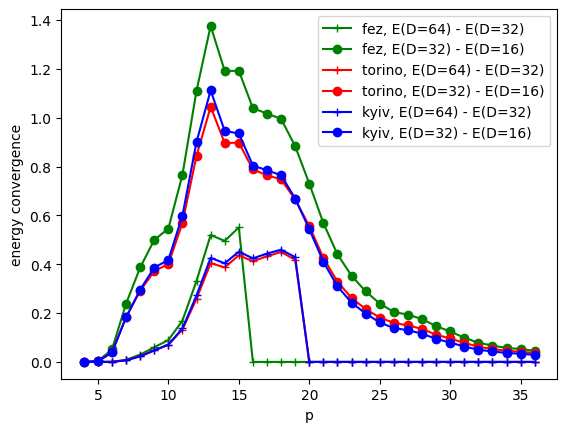

In [22]:
plot_energy_diff('fez', 16, 0)
plot_energy_diff('torino', 16, 0)
plot_energy_diff('kyiv', 16, 0)


In [24]:
def plot_energy(which, ang, les):

    ps = list(range(4,37))
    evs = []
    for p in ps:
        ind = (which, ang, les, p)
        ev1, ev2 = 0, 0
        for x in res[ind]:
            if x['D'] == '32' and x['env'] == 'BP':
                ev1 = float(x['eng'])
        evs.append(ev1)    

    plt.plot(ps, evs, '-+')

    plt.xlabel('p')
    plt.ylabel(f'E_32')
    plt.title(f"{which}, {ang}, {les}")


    # plt.legend()
# plt.show()

Energy for D=32

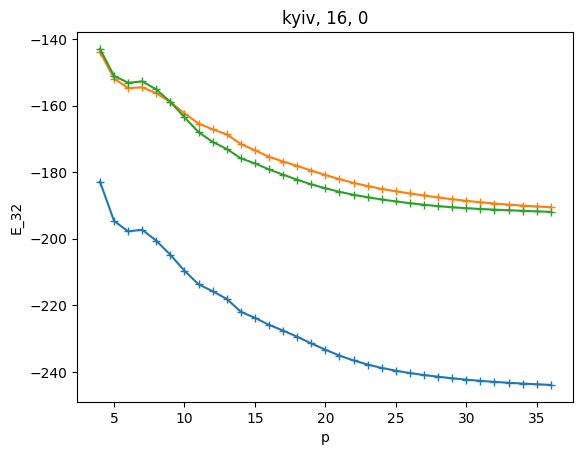

In [13]:
plot_energy('fez', 16, 0)
plot_energy('torino', 16, 0)
plot_energy('kyiv', 16, 0)

In [25]:
def plot_contraction_comparison(ind):

    clrs = {"BP": 'blue', "CTM": 'red', 'MPS': 'green'}
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5, 3)

    if ind in res:
        tmp = {(x['D'], x['env'], x['chi']): float(x['eng'])  for x in res[ind]}
        try:
            for D in [4, 8, 16, 32]:
                dE = tmp[(str(D), 'BP', '1')] - tmp[(str(D), 'MPS', '8')] 
                ax.scatter([1 / float(D)], abs(dE),
                            marker='+', color='b', s=100)
                
                dE = tmp[(str(D), 'BP', '1')] - tmp[(str(D), 'CTM', '8')] 
                ax.scatter([1 / float(D)], abs(dE),
                            marker='x', color='r', s=100)
        except KeyError:
            pass

    ax.set_yscale('log')
    ax.set_xlabel('1 / D')
    ax.set_ylabel(f'|E(MPS chi=8) - E(BP chi=1)|')
    ax.set_ylim(1e-6, 1e-0)
    ax.set_xlim(0, 0.26)

    ax.grid(which='major')
    ax.grid(which='minor')
    ax.set_title(f"{ind}")
    plt.show()

Here show convergence of energy (energy difference) between BP and MPS/CTM with chi=8

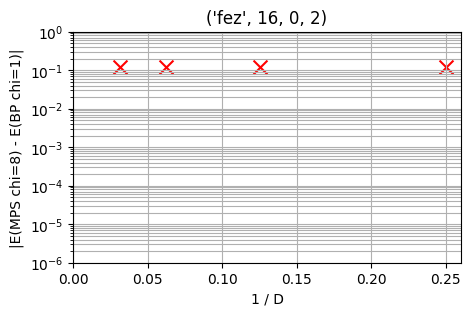

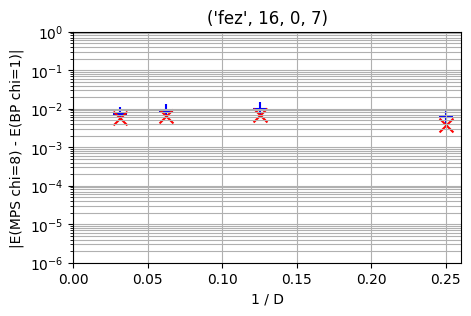

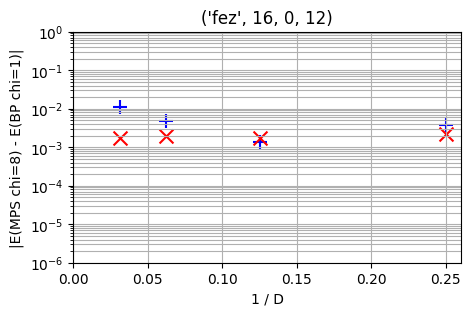

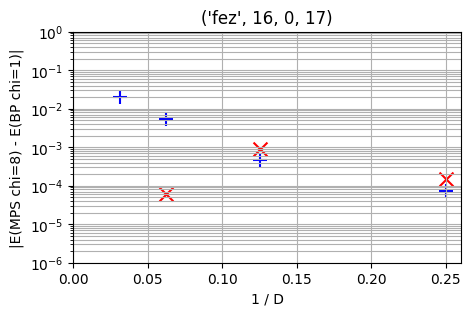

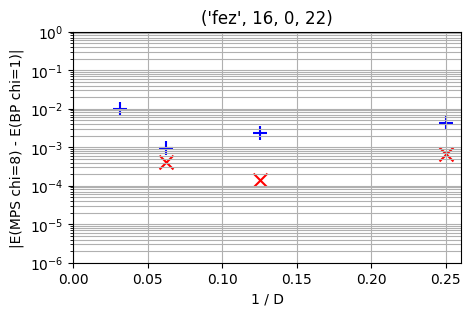

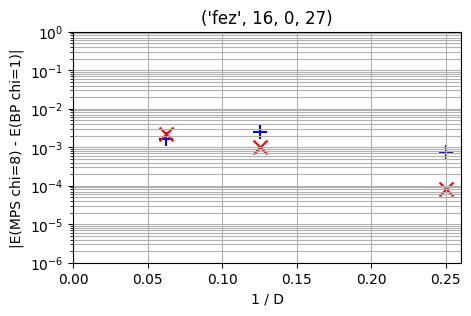

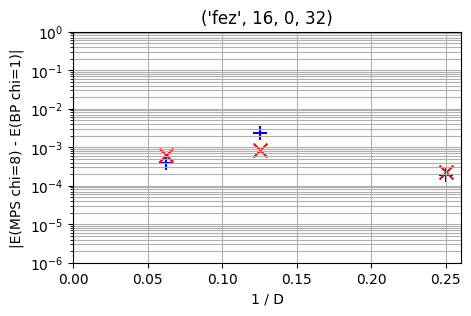

In [26]:
for p in range(2, 37, 5):
    plot_contraction_comparison(('fez', 16, 0, p))


In [27]:
smpls = {}
for which in ['fez', 'kyiv', 'torino']:
    for ang in [16]:
        for les in [0]:
            for p in range(37):
                for D in [8, 32]:
                    fname = Path(f"./results/Hamiltonian_ibm_{which}_0/{ang}_{les}/{p=}/samples_D={D}_CTM_chi=2.npy")
                    try:
                        ind = (which, ang, les, p, D)
                        smpls[ind] = np.load(fname, allow_pickle=True).item()
                    except FileNotFoundError:
                        pass

Text(0.5, 1.0, "('kyiv', 16, 0, 16)")

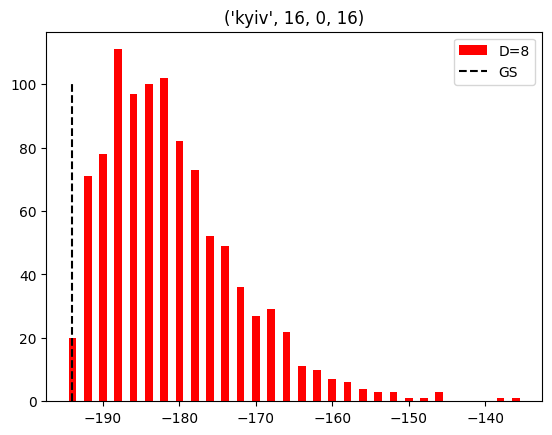

In [30]:
ind = ('kyiv', 16, 0, 16)
eng8 = smpls[ind + (8,)]["energies"]
#eng32 = smpls[ind + (32,)]["energies"]

plt.hist(eng8, bins=np.arange(min(eng8)-0.5, max(eng8)+0.6, 1), color=('r', 1), label="D=8");
plt.plot([-194,-194],[0, 100], '--k', label='GS')
plt.legend()
plt.title(ind)
#plt.hist(eng32, bins=np.arange(min(eng32), max(eng32)+1), color=('b', 0.5), label="D32")

